*** LOAD DATA ***

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from random import random
import os

from sklearn import preprocessing
from matplotlib import pylab
import random
from sklearn.manifold import TSNE

'''
data.columns
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted.Close',
       'ClosePast1', 'ClosePast2', 'ClosePast3', 'ClosePast4', 'ClosePast5',
       'ClosePast6', 'ClosePast7', 'ClosePast8', 'ClosePast9', 'ClosePast10',
       'ATR', 'SMI', 'ADX', 'BB', 'Aroon', 'Chaikin', 'MFI', 'SAR', 'Volat',
       'EMV', 'CLV', 'MACD', 'T.ind', 'Decision'],
      dtype='object')
'''
data_path = "/Users/bhan/Downloads/testdata/quandl/transform/"
ts_len = 1962
timesteps = 30

log = pd.read_table(os.path.join(data_path, "log.txt"), sep=' ',header=None)
filenames = log[log.ix[:,2] == ts_len].ix[:,0]


(918, 90, 29)

In [89]:
from keras import backend; print(backend._BACKEND)
import keras; print(keras.__version__)

tensorflow
1.0.4


In [52]:
# extract test data for ETL API impl
files = []
for name in filenames:
    f = pd.read_csv(os.path.join(data_path,name),usecols=['Date','Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted.Close'])
    f_tail = f.tail(30)
    f_tail.insert(0,"Symbol",name[6:-4])
    files.append(f_tail)

test_tsdata = pd.concat(files,0)
test_tsdata.shape
test_tsdata.to_csv("/Users/bhan/Downloads/testdata/quandl/transform/sample_stocks.csv", index=False)

In [79]:
def generate_seqs(df, n_next = 10, n_prev = 30):
    x_batches, y_batches = [], []
    for i in range(0, len(df)-n_prev, n_next):
        x_batches.append(df.iloc[i:i+n_prev].as_matrix())
        y_batches.append(df.iloc[i+n_prev].as_matrix())
    
    x_t = df.tail(n_prev).as_matrix()

    return x_batches, y_batches, x_t

def normalize_data(df):
    minmax_scaler = preprocessing.MinMaxScaler().fit(df)
    return minmax_scaler.transform(df)

x_seqs, y_seqs, x_test = [], [], []

for name in filenames:
    fdata = pd.read_csv(os.path.join(data_path,name),usecols=['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted.Close'])
    x, y, xt = generate_seqs(fdata)
    for i in range(len(x)):
        x[i] = normalize_data(x[i])
        y[i] = normalize_data(y[i])
    xt = normalize_data(xt)
    x_seqs +=x
    y_seqs +=y
    x_test.append(xt)

x_seqs = np.array(x_seqs)
y_seqs = np.array(y_seqs)
x_test = np.array(x_test)

print(x_seqs.shape, y_seqs.shape, x_test.shape)


(178092, 30, 6) (178092, 6) (918, 30, 6)


*** TRAIN AUTOENCODER ***

In [82]:

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
input_dim=6
lstm_steps=30
latent_dim=128

inputs = Input(shape=(lstm_steps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(lstm_steps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

seq_autoencoder = Model(input=inputs, output=decoded)

seq_autoencoder.compile(optimizer='RMSprop', loss='mse')
seq_autoencoder.fit(x_seqs,x_seqs,batch_size=64,nb_epoch=30)

encoder = Model(input=inputs, output=encoded)
# X_encoded = encoder.predict(x_test)

Epoch 1/30
178092/178092 [==============================] - 498s - loss: 0.0552   
Epoch 2/30
178092/178092 [==============================] - 483s - loss: 0.0449   
Epoch 3/30
178092/178092 [==============================] - 489s - loss: 0.0430   
Epoch 4/30
178092/178092 [==============================] - 488s - loss: 0.0413   
Epoch 5/30
178092/178092 [==============================] - 476s - loss: 0.0400   
Epoch 6/30
178092/178092 [==============================] - 469s - loss: 0.0390   
Epoch 7/30
178092/178092 [==============================] - 506s - loss: 0.0382   
Epoch 8/30
178092/178092 [==============================] - 487s - loss: 0.0378   
Epoch 9/30
178092/178092 [==============================] - 485s - loss: 0.0373   
Epoch 10/30
178092/178092 [==============================] - 479s - loss: 0.0371   
Epoch 11/30
178092/178092 [==============================] - 486s - loss: 0.0366   
Epoch 12/30
178092/178092 [==============================] - 484s - loss: 0.0362   
E

***GET ENCODINGS***

In [83]:

X_encoded = encoder.predict(x_test)


*** TSNE VIZ ***

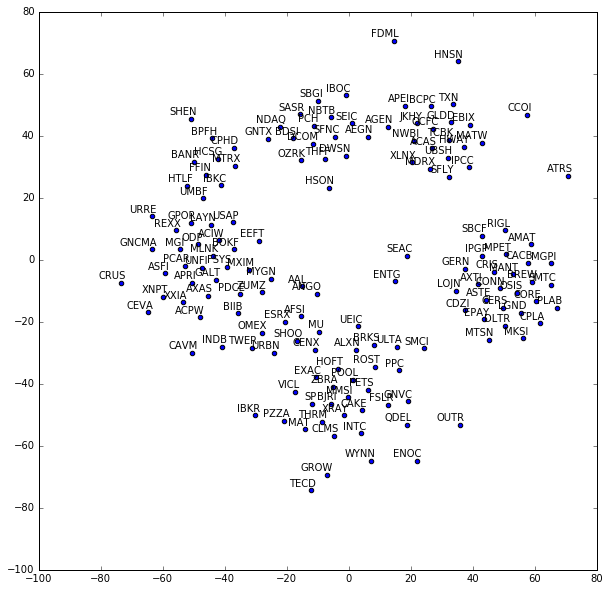

In [85]:
def plot_with_labels(two_dim_embs, labels):
    assert two_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    pylab.figure(figsize=(10, 10))  # inches
    for i, label in enumerate(labels):
        x, y = two_dim_embs[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label[6:-4], # remove .csv extension
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    pylab.show()

def sample_to_plot(num_samples, embs, labels):
    assert embs.shape[0] == len(labels), "number of labels doesn't match"
    idx_list = random.sample(range(embs.shape[0]),num_samples)
    l_embs, l_labels = [],[]
    for i in idx_list:
        l_embs.append(embs[i])
        l_labels.append(labels[i])
    return np.array(l_embs), l_labels    


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
n_samples = 150
embs, labels = sample_to_plot(n_samples, X_encoded, filenames.tolist())
tsne_embs = tsne.fit_transform(embs)
# labels = filenames.tail(n_samples)
plot_with_labels(tsne_embs, labels)

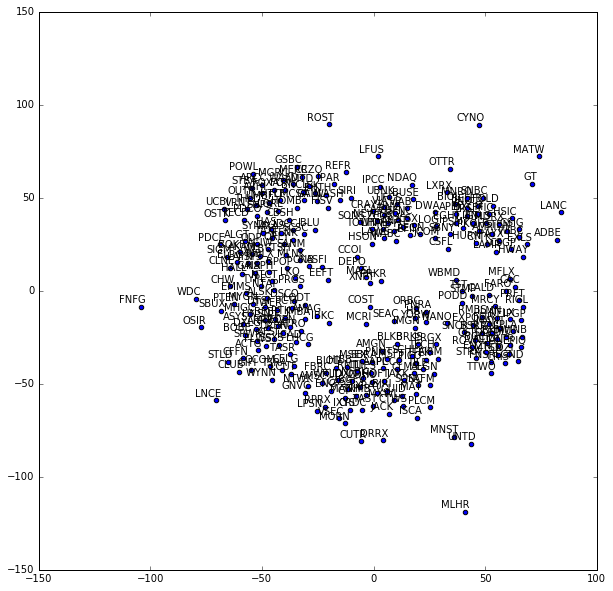

In [87]:
n_samples = 300
embs, labels = sample_to_plot(n_samples, X_encoded, filenames.tolist())
tsne_embs = tsne.fit_transform(embs)
# labels = filenames.tail(n_samples)
plot_with_labels(tsne_embs, labels)